In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abhi8923shriv/sentiment-analysis-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/abhi8923shriv/sentiment-analysis-dataset/versions/9


In [2]:
import pandas as pd

df=pd.read_csv(r'/root/.cache/kagglehub/datasets/abhi8923shriv/sentiment-analysis-dataset/versions/9/train.csv',encoding="latin1")
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [3]:
df = df[['text', 'sentiment']]
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [4]:
df.shape

(27481, 2)

In [5]:
df.isnull().sum()

,0
text,1
sentiment,0


In [6]:
df.dropna(inplace=True)

In [7]:
df.isnull().sum()

,0
text,0
sentiment,0


In [8]:
df = df[:5000].reset_index(drop=True)

In [9]:
df.shape

(5000, 2)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       5000 non-null   object
 1   sentiment  5000 non-null   object
dtypes: object(2)
memory usage: 78.3+ KB


In [11]:
df['sentiment'].value_counts()

,count
sentiment,
neutral,2022
positive,1593
negative,1385


<Axes: xlabel='count', ylabel='sentiment'>

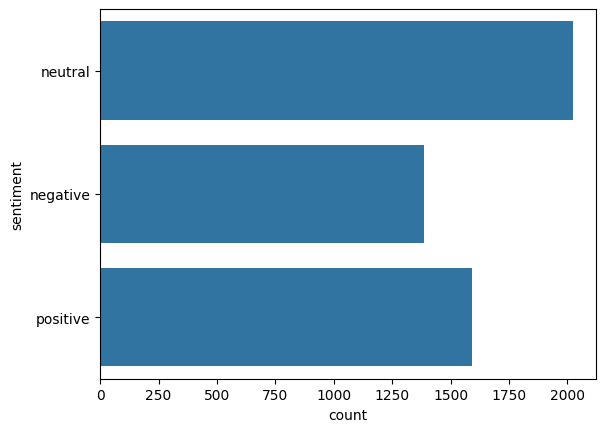

In [12]:
import seaborn as sns

sns.countplot(df['sentiment'])

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [14]:
df['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [15]:
mapping = {
    'positive': 2,
    'neutral': 1,
    'negative': 0
}

In [16]:
class_names = ['negative', 'neutral', 'positive']

In [17]:
df['sentiment'] = df['sentiment'].map(mapping)

In [18]:
df.head()

,text,sentiment
0,"I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0


In [19]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [20]:
len(train_df), len(test_df), len(val_df)

(4000, 500, 500)

#

In [21]:
!pip install transformers

In [22]:
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup

In [23]:
MODEL_NAME = 'bert-base-uncased'

In [24]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Choosing sequence length

In [25]:
token_length = []

for txt in df['text']:
  tokens = tokenizer.encode(txt, max_length=512)
  print(tokens)
  print(len(tokens))
  break

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[101, 1045, 1036, 1040, 2031, 5838, 1010, 2065, 1045, 2020, 2183, 102]
12


In [26]:
tokenizer.decode(101)

'[CLS]'

In [27]:
token_lens = []

for txt in df['text']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

And plot the distribution

<ipython-input-28-30003780af81>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


Text(0.5, 0, 'Token count')

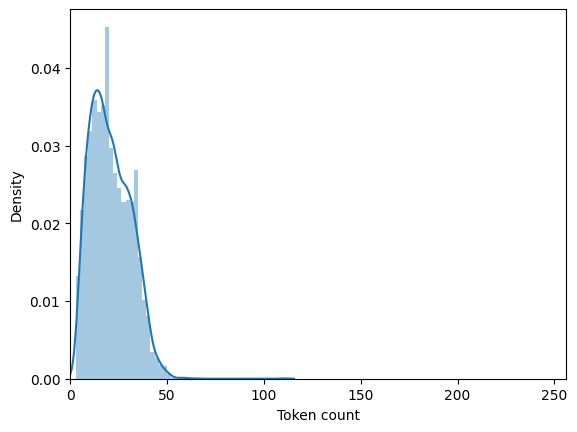

In [28]:
import matplotlib.pyplot as plt

sns.distplot(token_lens)
plt.xlim([0, 256])
plt.xlabel('Token count')

In [29]:
max(token_lens)

110

In [30]:
MAX_LEN = 80

# Dataset

In [68]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix

In [32]:
class SentimentDataset(torch.utils.data.Dataset):
  def __init__(self, review, target, tokenizer, max_len):
    self.review = review
    self.target = target
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.review)

  def __getitem__(self, idx):
    review = str(self.review[idx])

    encodings = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=self.max_len,
        padding='max_length',
        truncation=True,
        return_token_type_ids=False,
        return_attention_mask=True,
        return_tensors='pt'
    )

    return {
        'review_text': review,
        'input_ids': encodings['input_ids'].flatten(),
        'attention_mask': encodings['attention_mask'].flatten(),
        'targets': torch.tensor(self.target[idx], dtype=torch.long)
    }


# DataLoader

In [33]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = SentimentDataset(
      review=df['text'].to_numpy(),
      target=df['sentiment'].to_numpy(),
      tokenizer=tokenizer,
      max_len=max_len
  )

  return DataLoader(
      ds,
      batch_size=batch_size
  )

In [34]:
train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, batch_size=16)
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, batch_size=16)
val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, batch_size=16)

# Model creation

In [35]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    pooled_output = output.pooler_output  # or output[1]
    out = self.drop(pooled_output)
    return self.linear(out)

In [36]:
n_classes = len(class_names)

In [37]:
model = SentimentClassifier(n_classes)

In [38]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [39]:
model = model.to(device)

In [40]:
EPOCHS = 10
LEARNING_RATE = 2e-5

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [41]:
def train_epoch(model, data_loader, device, optimizer, scheduler, loss_fn, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:

    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    outputs = model(input_ids, attention_mask)
    _, preds = torch.max(outputs, dim=1)

    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)


In [42]:
def eval_model(model, data_loader, device, loss_fn, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets'].to(device)

      outputs = model(input_ids, attention_mask)
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [43]:
%%time
from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f"Epoch {epoch + 1}/{EPOCHS}")
  print('-' * 10)

  train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      device,
      optimizer,
      scheduler,
      loss_fn,
      len(train_df)
  )

  print(f"Train loss: {train_loss}, accuracy: {train_acc}")

  val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      device,
      loss_fn,
      len(val_df)
  )

  print(f"Val loss: {val_loss}, accuracy: {val_acc}")
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc


Epoch 1/10
----------
Train loss: 0.7943818725347519, accuracy: 0.64825
Val loss: 0.6562556549906731, accuracy: 0.734

Epoch 2/10
----------
Train loss: 0.50365419241786, accuracy: 0.80525
Val loss: 0.6294981404207647, accuracy: 0.758

Epoch 3/10
----------
Train loss: 0.32594577711075545, accuracy: 0.88525
Val loss: 0.735269099008292, accuracy: 0.744

Epoch 4/10
----------
Train loss: 0.1987263319455087, accuracy: 0.94025
Val loss: 0.9913978465483524, accuracy: 0.748

Epoch 5/10
----------
Train loss: 0.14064263772591948, accuracy: 0.9590000000000001
Val loss: 1.1275834085972747, accuracy: 0.75

Epoch 6/10
----------
Train loss: 0.08160834494885057, accuracy: 0.977
Val loss: 1.2402834579334012, accuracy: 0.748

Epoch 7/10
----------
Train loss: 0.048204459741711614, accuracy: 0.9862500000000001
Val loss: 1.3400749123575224, accuracy: 0.746

Epoch 8/10
----------
Train loss: 0.0299042267606128, accuracy: 0.99225
Val loss: 1.4441784405098588, accuracy: 0.756

Epoch 9/10
----------
Train

(0.0, 1.0)

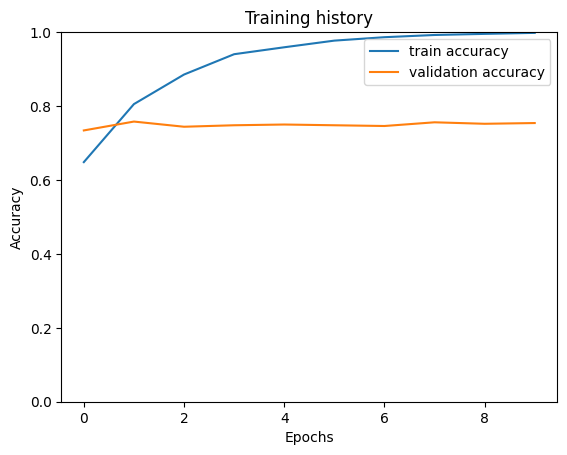

In [65]:
# plt.plot(history['train_acc'], label='train accuracy')
# plt.plot(history['val_acc'], label='validation accuracy')

plt.plot([t.cpu().item() for t in history['train_acc']], label='train accuracy')
plt.plot([t.cpu().item() for t in history['val_acc']], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.ylim([0, 1])

# Evaluation

In [63]:
test_acc, test_loss = eval_model(model, test_data_loader, device, loss_fn, len(test_df))

test_acc

tensor(0.7620, device='cuda:0', dtype=torch.float64)

We'll define a helper function to get the predictions from out model

In [46]:
a = next(iter(test_data_loader))
a.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [59]:
input_ids = a['input_ids'].to(device)
attention_mask = a['attention_mask'].to(device)

In [49]:
model(a['input_ids'].to(device), a['attention_mask'].to(device))

tensor([[-1.7810,  5.5730, -3.2500],
        [-2.1362, -2.8875,  5.1092],
        [-2.1355,  5.5102, -2.9585],
        [-3.4055,  4.5157, -0.9649],
        [-1.3304,  4.6799, -3.3246],
        [-2.5139,  5.7894, -2.7743],
        [-3.2413, -1.4208,  4.8385],
        [-2.6669,  5.4178, -2.4481],
        [ 5.3126, -3.3543, -3.0903],
        [-2.2044,  4.4405, -1.8439],
        [ 0.7599,  2.3023, -2.8747],
        [-2.8320, -2.8733,  6.1458],
        [-2.6070, -2.9582,  5.6704],
        [ 5.4455, -3.1808, -3.3643],
        [-3.2003,  2.0868,  2.4126],
        [-2.6900,  5.7720, -2.4217]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [58]:
nn.Softmax(model(a['input_ids'].to(device), a['attention_mask'].to(device)))

Softmax(
  dim=tensor([[-1.7810,  5.5730, -3.2500],
          [-2.1362, -2.8875,  5.1092],
          [-2.1355,  5.5102, -2.9585],
          [-3.4055,  4.5157, -0.9649],
          [-1.3304,  4.6799, -3.3246],
          [-2.5139,  5.7894, -2.7743],
          [-3.2413, -1.4208,  4.8385],
          [-2.6669,  5.4178, -2.4481],
          [ 5.3126, -3.3543, -3.0903],
          [-2.2044,  4.4405, -1.8439],
          [ 0.7599,  2.3023, -2.8747],
          [-2.8320, -2.8733,  6.1458],
          [-2.6070, -2.9582,  5.6704],
          [ 5.4455, -3.1808, -3.3643],
          [-3.2003,  2.0868,  2.4126],
          [-2.6900,  5.7720, -2.4217]], device='cuda:0',
         grad_fn=<AddmmBackward0>)
)

In [57]:
import torch.nn.functional as F
F.softmax(model(a['input_ids'].to(device), a['attention_mask'].to(device)), dim=1)

tensor([[6.3950e-04, 9.9921e-01, 1.4719e-04],
        [7.1270e-04, 3.3622e-04, 9.9895e-01],
        [4.7774e-04, 9.9931e-01, 2.0979e-04],
        [3.6130e-04, 9.9549e-01, 4.1478e-03],
        [2.4464e-03, 9.9722e-01, 3.3303e-04],
        [2.4759e-04, 9.9956e-01, 1.9082e-04],
        [3.0904e-04, 1.9083e-03, 9.9778e-01],
        [3.0802e-04, 9.9931e-01, 3.8336e-04],
        [9.9960e-01, 1.7212e-04, 2.2412e-04],
        [1.2964e-03, 9.9684e-01, 1.8592e-03],
        [1.7537e-01, 8.2000e-01, 4.6287e-03],
        [1.2615e-04, 1.2105e-04, 9.9975e-01],
        [2.5408e-04, 1.7884e-04, 9.9957e-01],
        [9.9967e-01, 1.7927e-04, 1.4921e-04],
        [2.1153e-03, 4.1837e-01, 5.7952e-01],
        [2.1125e-04, 9.9951e-01, 2.7625e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [60]:
outputs = model(input_ids, attention_mask)
_, preds = torch.max(outputs, dim=1)

In [61]:
print(_)

tensor([5.5730, 5.1092, 5.5102, 4.5157, 4.6799, 5.7894, 4.8385, 5.4178, 5.3126,
        4.4405, 2.3023, 6.1458, 5.6704, 5.4455, 2.4126, 5.7720],
       device='cuda:0', grad_fn=<MaxBackward0>)


In [62]:
print(preds)

tensor([1, 2, 1, 1, 1, 1, 2, 1, 0, 1, 1, 2, 2, 0, 2, 1], device='cuda:0')


# Prediction

In [66]:
import torch.nn.functional as F

def get_predictions(model, data_loader):
  model = model.eval()

  review_text = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      review_text = d['review_text']
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets'].to(device)

      outputs = model(input_ids, attention_mask)
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_text.extend(review_text)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()

  return review_text, predictions, prediction_probs, real_values


In [67]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [69]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.77      0.76      0.77       131
     neutral       0.72      0.71      0.72       207
    positive       0.80      0.83      0.81       162

    accuracy                           0.76       500
   macro avg       0.77      0.77      0.77       500
weighted avg       0.76      0.76      0.76       500



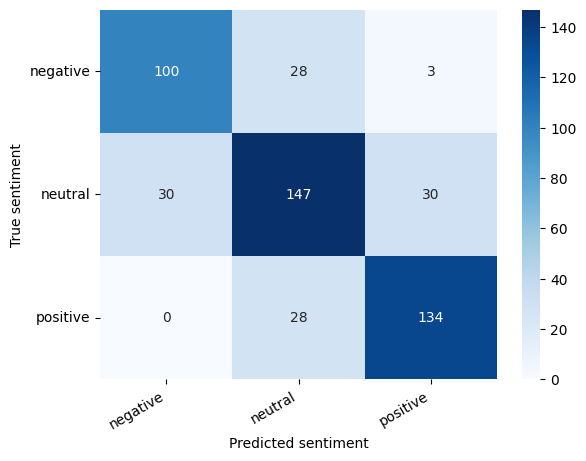

In [70]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [71]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]

pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': y_pred_probs[idx]
})

In [73]:
from textwrap import wrap

print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Had a great weekend with One, hanging with Nick & Brendon, church this
morning! Can`t believe Loretta won the Mothers Day raffle again!

True sentiment: neutral


(0.0, 1.0)

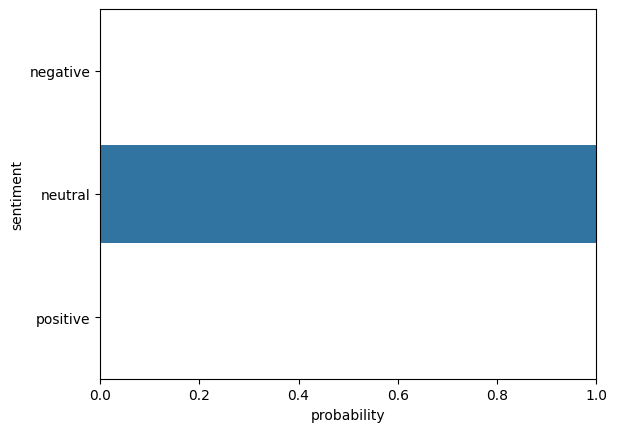

In [75]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1])

# Predicting RAW text

In [76]:
review_text = "I love completing my todos! Best app ever!!"

In [78]:
encoding = tokenizer.encode_plus(
    review_text,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False,
    return_attention_mask=True,
    return_tensors='pt'
)

input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f"Text: {review_text}")
print(f"Sentiment: {class_names[prediction]}")

Text: I love completing my todos! Best app ever!!
Sentiment: positive


In [82]:
a = torch.argmax(output)

In [83]:
a

tensor(2, device='cuda:0')

In [84]:
class_names[a]

'positive'